In [1]:
import sys
import os
import cv2

# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten

import splitfolders

print(sys.executable)

/home/trazom/venvs/Machine_Learning/bin/python3


In [2]:
def getFrame(video_path, image_path, sec, count=1):
    vidcap = cv2.VideoCapture(video_path)
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames, image = vidcap.read()
    if hasFrames:
        cv2.imwrite(image_path + "/image"+str(count)+".jpg", image)     # save frame as JPG file
    return hasFrames

def video2image(video_path, image_path, frameRate=0.1):
    for directories in os.listdir(video_path):
        for videos in os.listdir(video_path + directories):
            save_path = image_path + directories

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            video = video_path + directories + "/" + videos

            count = 1
            sec = 0

            success = getFrame(video_path=video, image_path=save_path, sec=sec)
            while success:
                count = count + 1
                sec = sec + frameRate
                sec = round(sec, 2)
                success = getFrame(video_path=video, image_path=save_path, sec=sec, count=count)



In [3]:
# video_directory = "/home/trazom/Internship Project/Video Data/"
# image_directory = "/home/trazom/Internship Project/Image Data/"


# video2image(video_directory, image_directory, 0.03)

In [4]:
# # Creating Train / Val / Test folders (One time use)


split_output = "/home/trazom/Internship Project/Split Image Data/"

#splitfolders.ratio(image_directory, output=split_output, seed=1337, ratio=(.6, 0.2, 0.2))

In [5]:
im = cv2.imread(split_output + "train/Ab trainer/image1.jpg")

In [6]:
print(im.shape)

(1280, 720, 3)


# Here begins the Machine Learning

## Part 1 - Building the CNN

## Build Model

In [21]:
classes = []
for directories in os.listdir(split_output + "train"):
    classes.append(directories)

no_of_classes = len(classes)
print(classes, no_of_classes)

['Recumbent exercise bike', 'Versa Climber', 'Rowing Machine', 'Weight Tree', 'Ab trainer', 'Step climber', 'Upright bike', 'Hitmill X', 'Thread mill'] 9


In [22]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        split_output + "train",  # This is the source directory for training images
        target_size=(512, 288),  # All images will be resized to 512 x 288
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = classes,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1/255)

validation_generator = validation_datagen.flow_from_directory(
        split_output + 'val',  # This is the source directory for training images
        target_size=(512, 288),  # All images will be resized to 512 x 288
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = classes,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')



model = Sequential([
    # Note the input shape is the desired size of the image 512 x 288 
    # with 3 bytes color
    # The first convolution
    Conv2D(16, (3,3), activation='relu', input_shape=(512, 288, 3)),
    MaxPooling2D(2, 2),
    # The second convolution
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The third convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fourth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # The fifth convolution
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    Flatten(),
    # 128 neuron in the fully-connected layer
    Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    Dense(no_of_classes, activation='softmax')
])


model.summary()



Found 4344 images belonging to 9 classes.
Found 1446 images belonging to 9 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 510, 286, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 255, 143, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 253, 141, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 70, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 68, 64)       18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 34, 64)        0         
____________________________________

In [23]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

total_sample=train_generator.n

n_epochs = 30

history = model.fit(train_generator,
                    steps_per_epoch=int(total_sample/batch_size),
                    epochs=n_epochs,
                    validation_data=validation_generator,
                    verbose=2)

model.save('model_better.h5')

Epoch 1/30
271/271 - 65s - loss: 0.7594 - acc: 0.7521 - val_loss: 2.6984 - val_acc: 0.5788
Epoch 2/30
271/271 - 63s - loss: 0.1429 - acc: 0.9829 - val_loss: 6.1786e-05 - val_acc: 1.0000
Epoch 3/30
271/271 - 63s - loss: 0.7381 - acc: 0.9933 - val_loss: 1.0110e-06 - val_acc: 1.0000
Epoch 4/30
271/271 - 64s - loss: 0.1553 - acc: 0.9945 - val_loss: 0.0065 - val_acc: 0.9972
Epoch 5/30
271/271 - 63s - loss: 0.1504 - acc: 0.9961 - val_loss: 7.6670e-09 - val_acc: 1.0000
Epoch 6/30
271/271 - 62s - loss: 0.3480 - acc: 0.9919 - val_loss: 0.0029 - val_acc: 0.9986
Epoch 7/30
271/271 - 63s - loss: 0.0928 - acc: 0.9963 - val_loss: 2.3768e-06 - val_acc: 1.0000
Epoch 8/30
271/271 - 63s - loss: 1.3945e-07 - acc: 1.0000 - val_loss: 4.9464e-10 - val_acc: 1.0000
Epoch 9/30
271/271 - 63s - loss: 6.8859e-10 - acc: 1.0000 - val_loss: 2.1846e-08 - val_acc: 1.0000
Epoch 10/30
271/271 - 63s - loss: 0.0658 - acc: 0.9970 - val_loss: 5.5235e-09 - val_acc: 1.0000
Epoch 11/30
271/271 - 63s - loss: 8.2631e-10 - acc: 1

In [24]:

import numpy as np
from keras.preprocessing import image
#test_image = image.load_img("/home/trazom/Internship Project/Split Image Data/test/Rowing Machine/image7.jpg", target_size = (512 x 288))
#test_image = image.img_to_array(test_image)
test_image = image.load_img("/home/trazom/Internship Project/Split Image Data/test/Step climber/image545.jpg", target_size = (512, 288))

test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

for i in range(no_of_classes):
    if result[0][i] == 1:
        print(classes[i])




Step climber


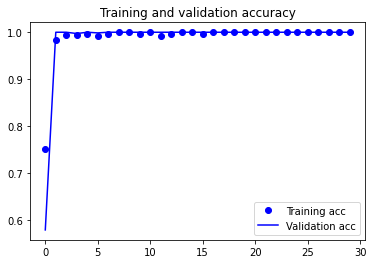

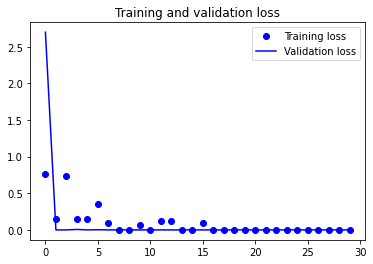

In [32]:
import matplotlib.pyplot as plt
image_folder = "/home/trazom/Internship Project/Internship Report/Images/"
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig(image_folder + 'accuraccy.png')
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(image_folder + 'loss.png')
plt.show()


## Evaluating model on test set

In [34]:
# Create a generator

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    split_output + 'test',  # This is the source directory for training images
    target_size=(512, 288),  # All images will be resized to 512 x 288
    shuffle = False,    
    batch_size=1,
    # Specify the classes explicitly
    classes = classes,
    # Since we use categorical_crossentropy loss, we need categorical labels
    class_mode='categorical')



Found 1454 images belonging to 9 classes.


In [35]:
# Predict

import numpy

test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)


predictions = model.predict(test_generator,
                            batch_size = batch_size,
                            steps=test_steps_per_epoch,
                            verbose=1
                      )

predicted_classes = numpy.argmax(predictions, axis=1)


1454/1454 [==============================] - 16s 11ms/step


In [36]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [41]:
import sklearn.metrics as metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\n\n\n\n", report, "\n\n\n\n")    

reporter = metrics.confusion_matrix(true_classes, predicted_classes)
print("\n\n\n\n", reporter, "\n\n\n\n")    







                          precision    recall  f1-score   support

Recumbent exercise bike       1.00      1.00      1.00       148
          Versa Climber       1.00      1.00      1.00        84
         Rowing Machine       1.00      1.00      1.00       125
            Weight Tree       1.00      1.00      1.00       153
             Ab trainer       1.00      1.00      1.00       106
           Step climber       1.00      1.00      1.00       158
           Upright bike       1.00      1.00      1.00       252
              Hitmill X       1.00      1.00      1.00       140
            Thread mill       1.00      1.00      1.00       288

               accuracy                           1.00      1454
              macro avg       1.00      1.00      1.00      1454
           weighted avg       1.00      1.00      1.00      1454
 








 [[148   0   0   0   0   0   0   0   0]
 [  0  84   0   0   0   0   0   0   0]
 [  0   0 125   0   0   0   0   0   0]
 [  0   0   0 153   

In [39]:
reporter = metrics.confusion_matrix(true_classes, predicted_classes)
print(reporter)    


[[148   0   0   0   0   0   0   0   0]
 [  0  84   0   0   0   0   0   0   0]
 [  0   0 125   0   0   0   0   0   0]
 [  0   0   0 153   0   0   0   0   0]
 [  0   0   0   0 106   0   0   0   0]
 [  0   0   0   0   0 158   0   0   0]
 [  0   0   0   0   0   0 252   0   0]
 [  0   0   0   0   0   0   0 140   0]
 [  0   0   0   0   0   0   0   0 288]]


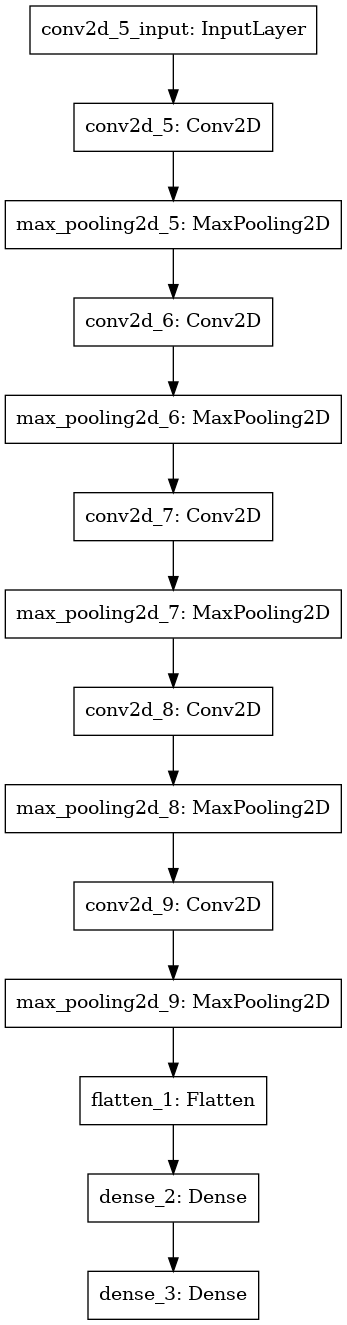

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file= image_folder + 'model.png')

## New heading